# Método metrópolis para múltiple puebas aleatorias

dependiendo de los datos hay que recordar cambiar los rangos del priori, de m_v y b_v, y además reacomodar la función nueva a la que deseamos aproximar(f).

In [106]:
 #%reset

In [107]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import pickle
import matplotlib.colors as mcolors

In [108]:
data = np.load('test_line.npy') 
#data

x = data[0,:]      #primer renglón
#print(len(x))
x_avrg = x.mean
y = data[1,:]      #segundo renglón
y_err = data[2,:]  #tercer renglón
n = len(x)

#print(len(data))

In [109]:
"""definimos la función con la que aproximaremos nuestro likelihood, en este caso es una func. lineal"""

def f(x,pendiente,cte):
    f = pendiente*x + cte
    return f

"""definimos una función para el likelihood"""
def LogLikelihood(x,pendiente,cte,y,DesviacionEstandar):
    LogL=0
    n = len(x)
    for i in range(n):
        LogL = LogL - ((y[i] - f(x[i],pendiente,cte))**2)/(2*((DesviacionEstandar[i])**2)) -(n/2)*np.log(2*np.pi*(DesviacionEstandar[i])**2)
    return LogL


In [110]:
"""Vamos a definir una función en la que nosotros vamos a definir la probabilidad de encontrar nuestros
datos en un intervalo específico (en base l plot de x vs y)"""

"""La probabilidad (Prior de m) de encontrar a m en cierto intervalo"""

def Prior_m(pendiente):
    m_min = 15
    m_max = 25
    if m_min<= pendiente and pendiente<= m_max:
        Pm = 1/(m_max-m_min)
    else:
        Pm = 0
    return Pm

"""La probabilidad (Prior de b) de encontrar a b en cierto intervalo""" 

def Prior_b(cte):
    b_min = 100
    b_max = 250
    if b_min<= cte and cte <= b_max:
        Pb = 1/(b_max-b_min)
    else:
        Pb = 0
    return Pb

In [111]:
#definimos el posterior (la prob. de que nuestrosdatos sean correctos)
def Post(m_n,b_n,x,y,sigma):
    LogPos = np.log(Prior_m(m_n)) + np.log(Prior_b(b_n)) + (LogLikelihood(x,m_n,b_n,y,sigma))
    return LogPos

# Def múltiples Metropolis

In [112]:
def metropolis(n_pasos,m_v,b_v,x,y,y_err):

    Post_v = Post(m_v,b_v,x,y,y_err) #posterior

    mb = np.zeros([n_pasos + 1,2]) #contiene a TODOS los m y b
    mb[0] = [m_v,b_v]

    #aquí solo escribiremos los que sí pasen el filtro de metrópolis
    m_acep = []
    b_acep = []

    counting = 0
    
    for i in range(1,n_pasos):
        m_rnd = np.random.normal(m_v,0.2)  #m aleatorios
        b_rnd = np.random.normal(b_v,0.2)  #b aleatorios
    
        m_n = m_rnd  #aquí guardamos moentáneamente 'm'
        b_n = b_rnd #aquí guardamos moentáneamente 'b'
    
        Post_n = Post(m_n,b_n,x,y,y_err)
        #print(Post_n)
        mb[i+1] = [m_n,b_n]
    
        if Post_n > Post_v: #comparamos si el likelihood nuevo es mayor al viejo
        
            """Reevaluamos los valores de nuestras constantes"""
        
            Post_v = np.copy(Post_n)
            m_v = np.copy(m_n)
            b_v = np.copy(b_n)
            #print('nuevo Posterior viejo',Post_v)
            #counting = counting+1
            m_acep.append(m_v)
            b_acep.append(b_v)
        
        
        
        elif Post_n - Post_v > np.random.rand():
            Post_v = np.copy(Post_n)
            m_v = np.copy(m_n)
            b_v = np.copy(b_n)
            #print('nuevo Posterior viejo',Post_v)
            counting = counting+1
            m_acep.append(m_v)
            b_acep.append(b_v)
            
            #print('m = ',m_n)
            #print('b = ',b_n) 
    #print('m = ',len(m_acep))
    #print('b = ',len(b_acep))
    
    resultados = [mb,m_acep,b_acep] #matriz con los resultados
    return resultados
    

In [113]:
n_pasos = 10000 #pasos del metrópolis

#puntos inciales del random walk
m_v = 15
b_v = 200
desv_estandar = 0.2

resultados = metropolis(n_pasos,m_v,b_v,x,y,y_err);

mb = resultados[0]
m_acep = resultados[1]
b_acep = resultados[2]


In [114]:
len(m_acep)

66

In [115]:
"""iteraciones del metropolis"""

#primer entrada es el número del walker
#la segunda entrada contiene los datos [mb, m aceptado, b aceptado]
def metro_walker(n_pasos,m_v,b_v,x,y,y_err,caminadores):
    walkers = []
    for i in range(caminadores):
        m_ini = np.random.normal(m_v,1)
        b_ini = np.random.normal(b_v,1)
        walkers.append(metropolis(n_pasos,m_ini,b_ini,x,y,y_err))
    return walkers

In [116]:
caminadores = 3 #no. de walks que deseamos calcular

"""matriz que contiene mb, m y b de cada walk que se dió"""
walkers = metro_walker(n_pasos,m_v,b_v,x,y,y_err,caminadores); 

# Visualización de datos

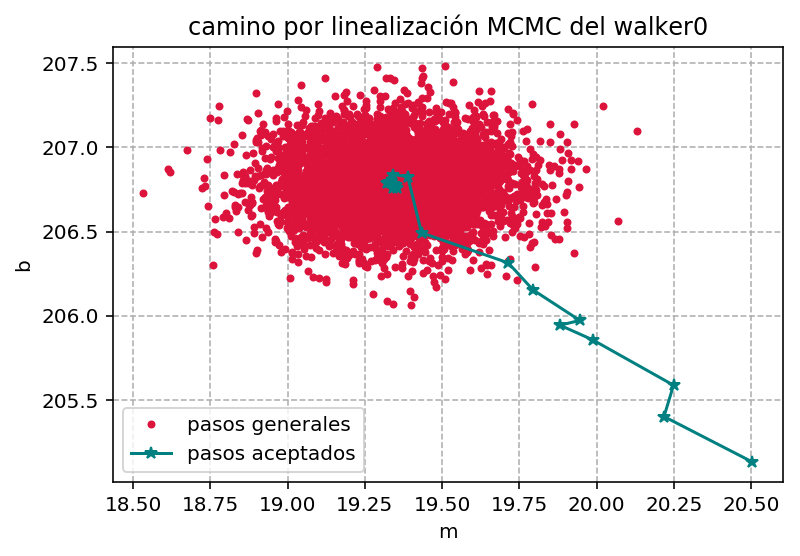

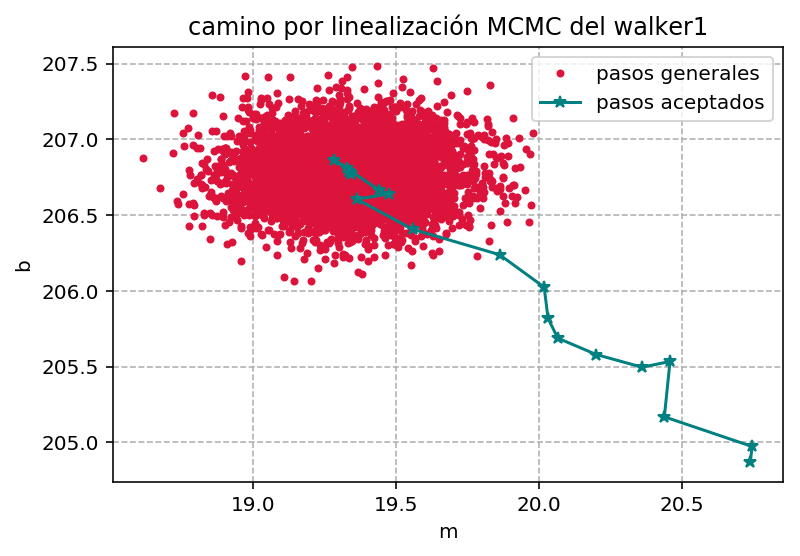

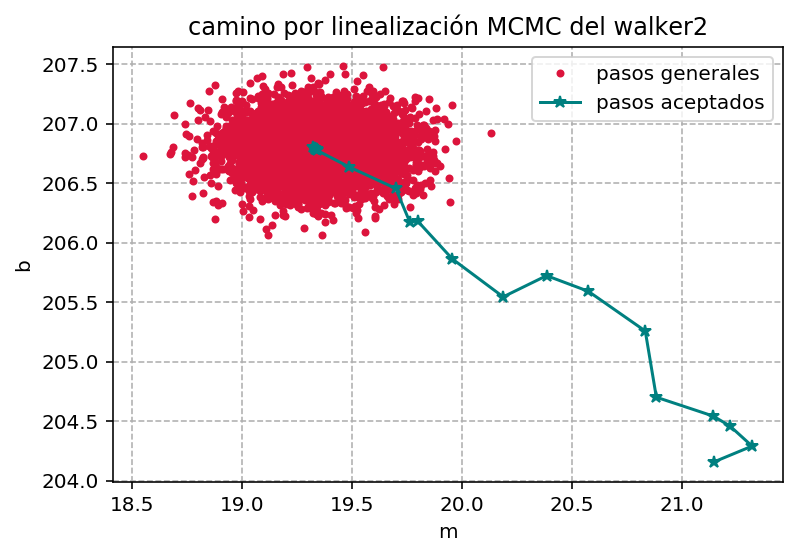

In [117]:
#walker[0][0][:,0] primer walker, matriz mb, con la primer entrada "m"
#walker[0][0][:,1] primer walker, matriz mb, con la segunda entrada "b"

#walkers[0][2] primer walker, mvector de b aceptados.
"""este ya están cortados aqlgunos puntos"""
for i in range(caminadores):
    plt.plot(walkers[i][0][-5000:,0],walkers[0][0][-5000:,1],'.', color = 'crimson',label = 'pasos generales')
    plt.plot(walkers[i][1][-20:],walkers[i][2][-20:],'-*', color = 'teal',label = 'pasos aceptados')
    plt.legend()
    plt.title('camino por linealización MCMC del walker' + str(i))
    plt.xlabel('m')
    plt.ylabel('b')
    plt.grid(linestyle='--')
    plt.show()
"""este es el camino completo"""
# for i in range(caminadores):
#     plt.plot(walkers[i][0][:,0],walkers[0][0][:,1],'.', color = 'crimson',label = 'pasos generales')
#     plt.plot(walkers[i][1],walkers[i][2],'-*', color = 'teal',label = 'pasos aceptados')
#     plt.legend()
#     plt.title('camino por linealización MCMC del walker' + str(i))
#     plt.xlabel('m')
#     plt.ylabel('b')
#     plt.grid(linestyle='--')
#     plt.show()

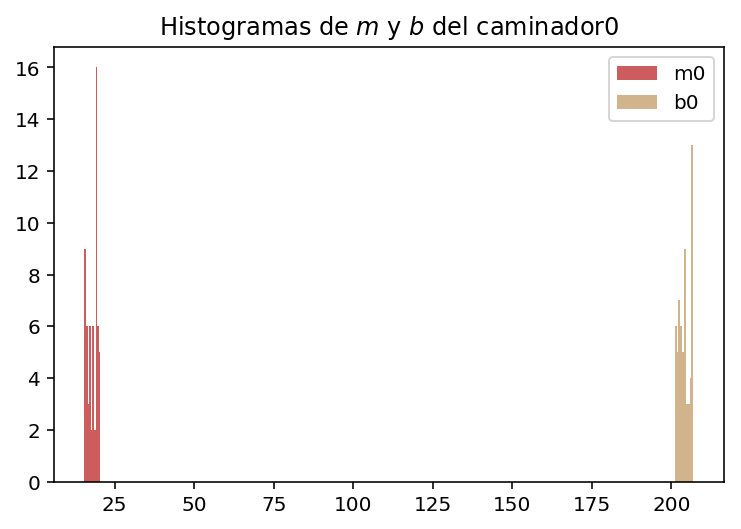

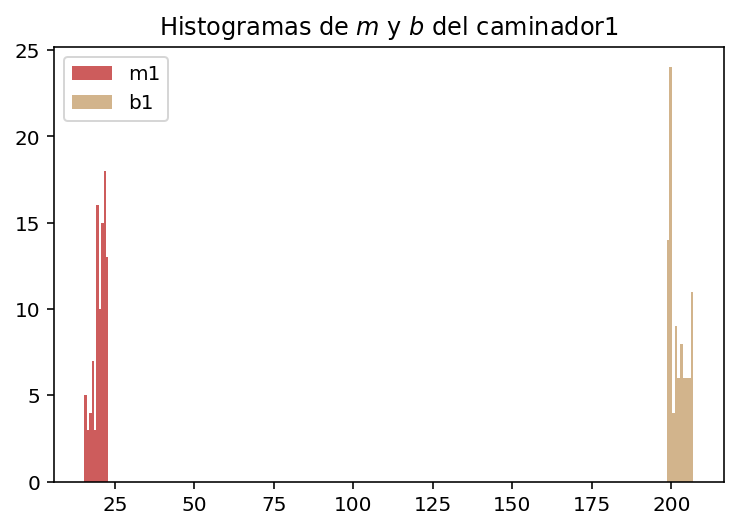

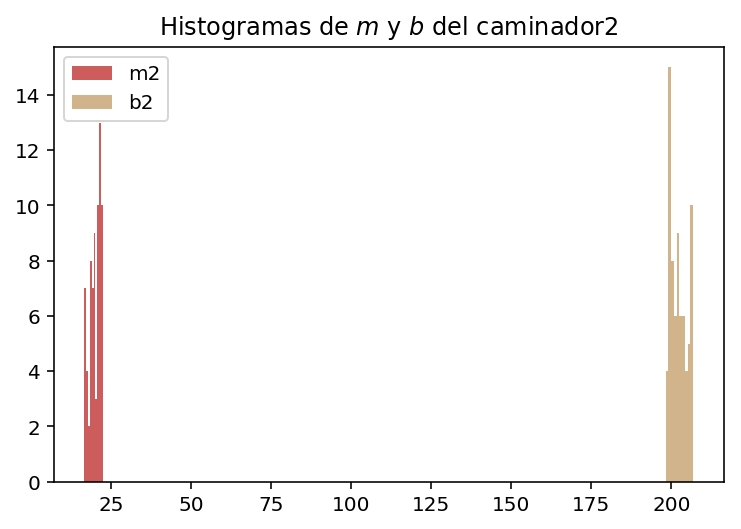

In [118]:
for i in range(caminadores):
    plt.hist(walkers[i][1],10, color = 'indianred', label = 'm'+str(i))
    plt.hist(walkers[i][2],10, color = 'tan', label = 'b'+str(i))
    plt.title('Histogramas de $m$ y $b$ del caminador'+ str(i))
    plt.legend()
    plt.show()

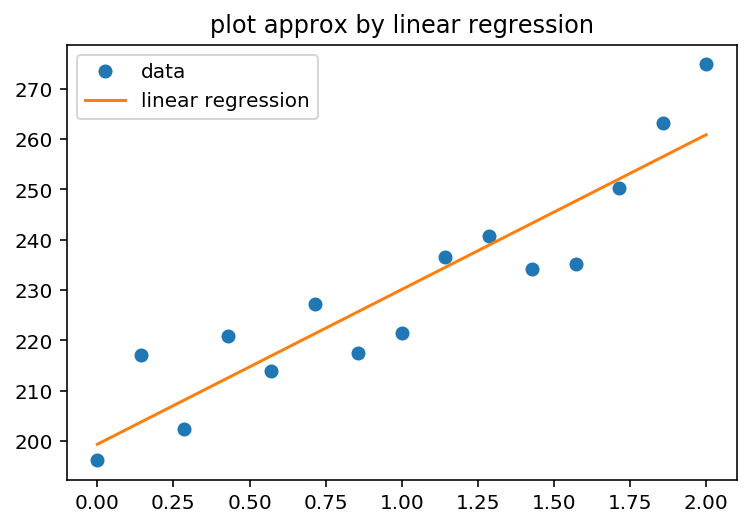

m approx by linear regression: 30.762307652444484
b approx by linear regression: 199.34272404405513


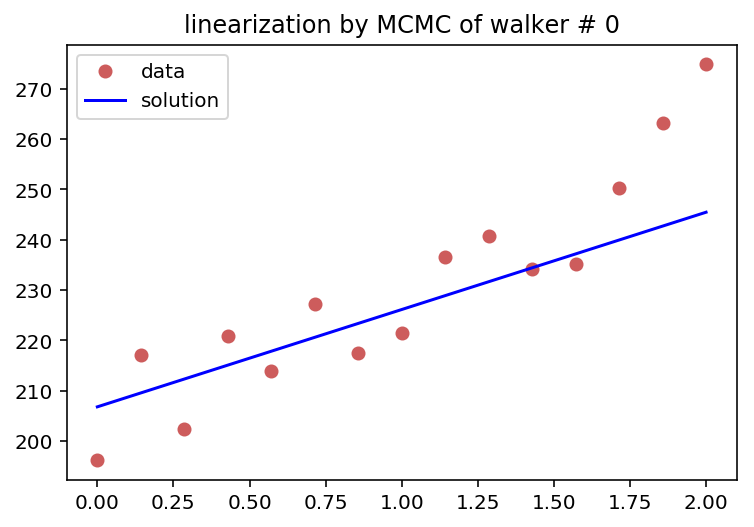

m approx by MCMC=  19.341944619172622
b approx by MCMC=  206.78180513447663


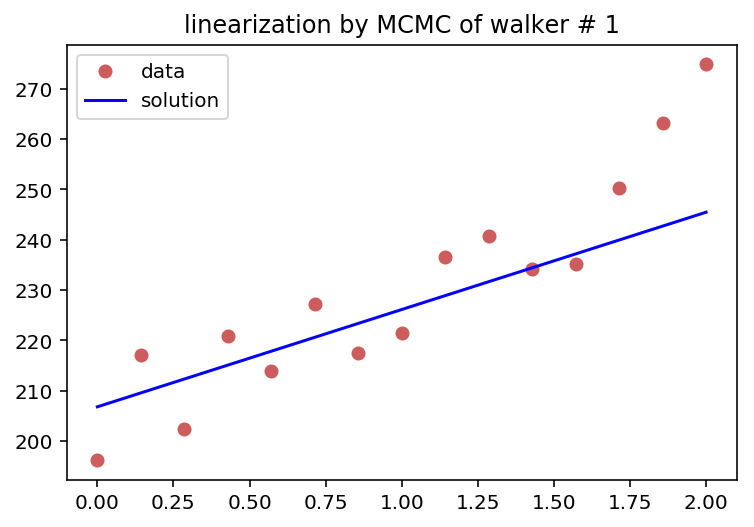

m approx by MCMC=  19.33948565765043
b approx by MCMC=  206.7847416048172


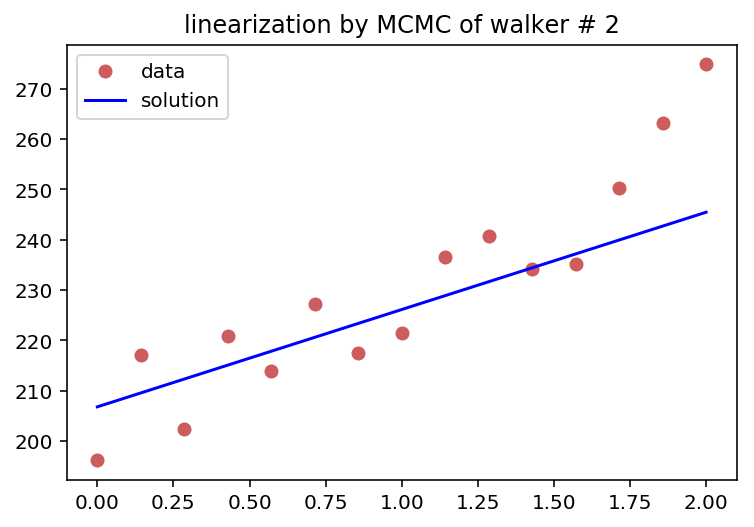

m approx by MCMC=  19.339775019108867
b approx by MCMC=  206.78282882368157


In [119]:
plt.plot(x,y,'o', label = 'data')
plt.plot(x, (30.762307652444484)*x + 199.34272404405513, label = 'linear regression')
plt.title('plot approx by linear regression')
plt.legend()
plt.show()

print('m approx by linear regression:',  30.762307652444484)
print('b approx by linear regression:', 199.34272404405513)
#-----------------------------------------------------------------------------------
# visualización de la linealización
#-----------------------------------------------------------------------------------
for i in range(caminadores):
    plt.plot(x,y,'o', color='indianred', label = 'data')
    plt.plot(x,f(x,walkers[i][1][-1],(walkers[i][2][-1])), color = 'b',label = 'solution')
    plt.title('linearization by MCMC of walker # ' + str(i))
    plt.legend()
    plt.show()

    print('m approx by MCMC= ',walkers[i][1][-1])
    print('b approx by MCMC= ',walkers[i][2][-1]) 

# German-Rubin diagnostic

# Convergencia de los parámetros m y b

In [120]:
def German_Rubin(caminadores,n_pasos,walkers):
    var_paramtr = np.zeros((caminadores,2)) #el 2 es por m y b
    avrg_param = np.zeros((caminadores,2))
    
    for i in range(caminadores):
        
        avrg_param[i] = np.array([np.mean(walkers[i][0][:,0]),np.mean(walkers[i][0][:,1])])
        
        var_paramtr[i,0] = np.var(walkers[i][0][:,0],ddof = 1)
        var_paramtr[i,1] = np.var(walkers[i][0][:,1],ddof = 1)
    
    if caminadores == 1:
        return 0
    else:
        s = [(np.square(var_paramtr[:,0]).sum())/caminadores, (np.square(var_paramtr[:,1]).sum())/caminadores]
        B_n = [(np.var(avrg_param[:,0], ddof = 1))/(caminadores - 1),(np.var(avrg_param[:,1], ddof = 1))/(caminadores - 1)]
        sigma =[(((n_pasos -1)*s[0])/n_pasos) + B_n[0], (((n_pasos -1)*s[1])/n_pasos) + B_n[1]]
        R = np.sqrt(np.divide(sigma,s))
        return R   

In [121]:
R = German_Rubin(caminadores,n_pasos,walkers)
#si R > 1 la solución puede converger
R

array([1.00231811, 0.99995804])

In [122]:
def German_Rubin1(caminadores,n_pasos,walkers):
    var_paramtr = np.zeros((caminadores,2)) #el 2 es por m y b
    avrg_param = np.zeros((caminadores,2))
    
    for i in range(caminadores):
        
        avrg_param[i] = np.array([np.mean(walkers[i][0][:,0]),np.mean(walkers[i][0][:,1])])
        
        var_paramtr[i,0] = np.var(walkers[i][0][:,0],ddof = 1)
        var_paramtr[i,1] = np.var(walkers[i][0][:,1],ddof = 1)
    
        s = [(np.square(var_paramtr[:,0]).sum())/caminadores, (np.square(var_paramtr[:,1]).sum())/caminadores]
        B_n = [(np.var(avrg_param[:,0], ddof = 1))/(caminadores - 1),(np.var(avrg_param[:,1], ddof = 1))/(caminadores - 1)]
        sigma =[(((n_pasos -1)*s[0])/n_pasos) + B_n[0], (((n_pasos -1)*s[1])/n_pasos) + B_n[1]]
        R = np.sqrt(np.divide(sigma,s))
        
        delta = np.random.rand()*10
    if 1<= np.all(R) and np.all(R) <= delta:
        print('la solución converge')
        return R
    else:
        print('La solución no converge')
        return 0

In [123]:
R1 = German_Rubin1(caminadores,n_pasos,walkers)
R1

la solución converge


array([1.00231811, 0.99995804])

# Gráficos triangulares

In [124]:
# Show plots inline, and load main getdist plot module and samples class
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
# use this *after* importing getdist if you want to use interactive plots
# %matplotlib notebook
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True

GetDist Version: 1.1.2, Matplotlib version: 2.2.2


In [125]:
# Get some random samples for demonstration:
# make random covariance, then independent samples from Gaussian
ndim = caminadores*2
nsamp = n_pasos

np.random.seed(10)

A = np.random.rand(ndim,ndim)
cov = np.dot(A, A.T)
cov.fill(desv_estandar) #esto llena la matriz de covarianza

In [126]:
samps = walkers[0][0]
"""que disque agrega columnas"""
for i in range(1,caminadores):
    samps = np.c_[samps, walkers[i][0]]
    
#len(samps)
#samps

In [127]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
names = ["x%s"%i for i in range(ndim)]
labels =  ["x_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')

Removed no burn in


C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `a

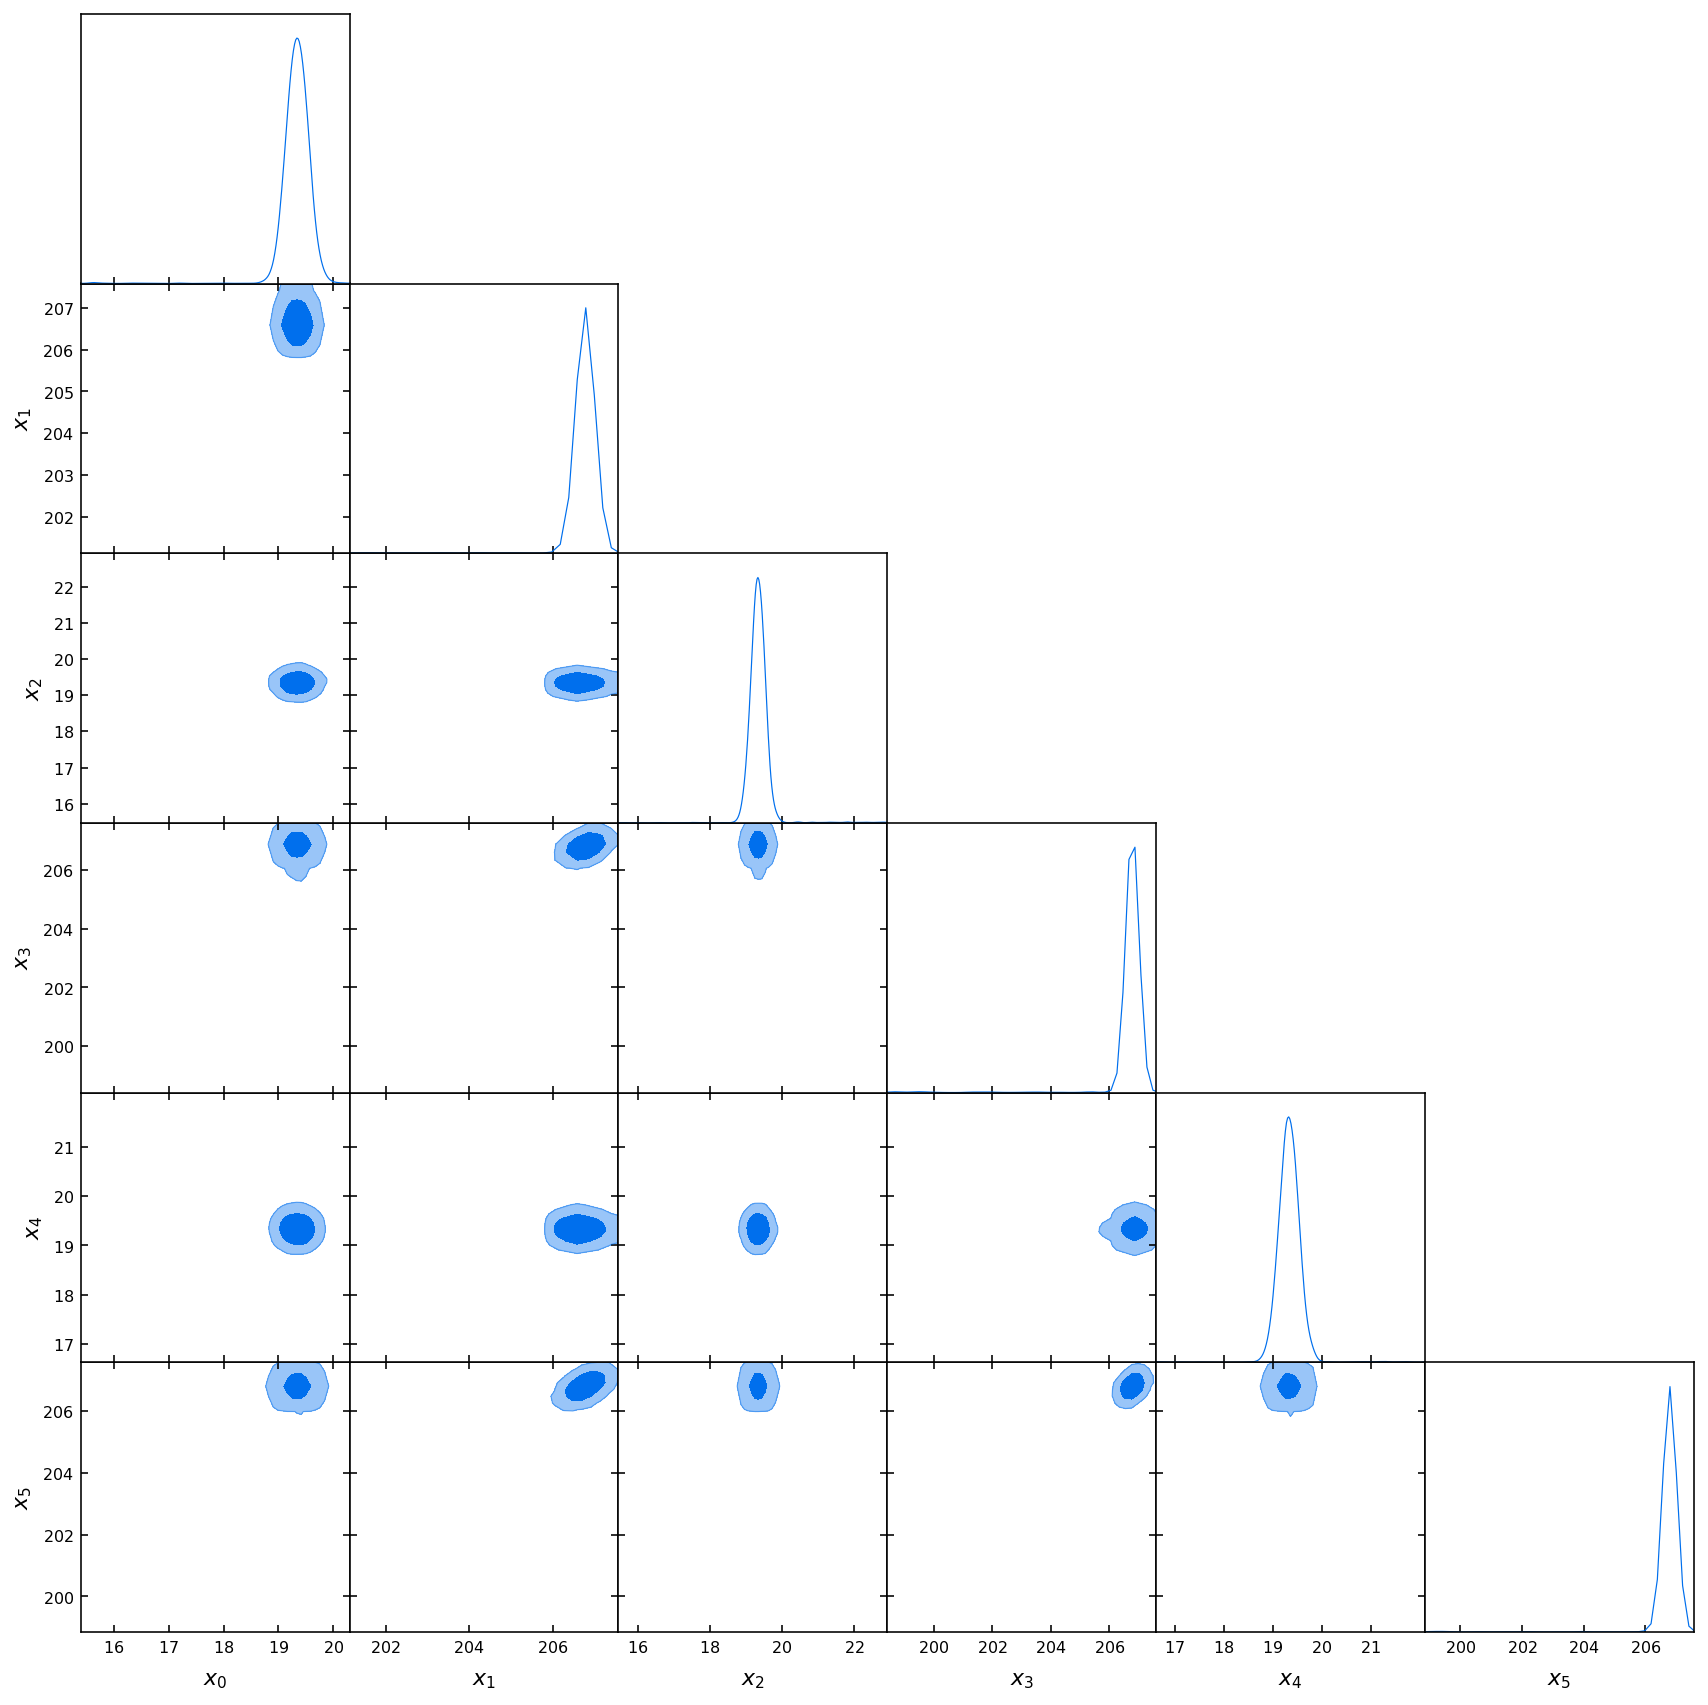

In [128]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True);

# Ddatos filtrados por metrópolis

In [129]:
samplesm = walkers[0][1][-5:]
samplesb = walkers[0][2][-5:]

for i in range(1,caminadores):
    samplesm = np.c_[samplesm, walkers[i][1][-5:]]
    
for i in range(1,caminadores):
    samplesb = np.c_[samplesb, walkers[i][2][-5:]]


In [130]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity

names = ["x%s"%i for i in range(caminadores)]
labels =  ["x_%s"%i for i in range(caminadores)]

sampmAccpt = MCSamples(samples= samplesm ,names = names, labels = labels)

sampbAccpt = MCSamples(samples= samplesb ,names = names, labels = labels, label='Second set')

Removed no burn in
Removed no burn in


In [131]:
#samplesm

In [132]:
# whos

C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


IndexError: index 1 is out of bounds for axis 0 with size 1

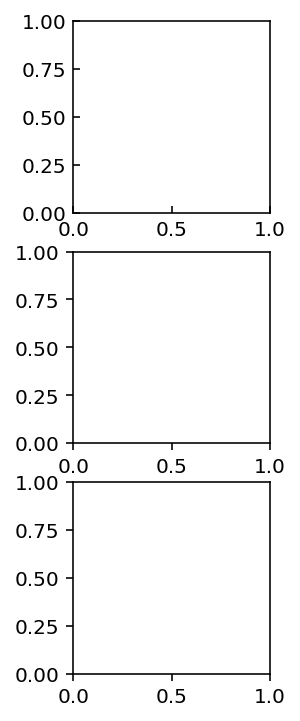

In [133]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([sampmAccpt,sampbAccpt], filled=True);

In [134]:
Mtot = walkers[0][0][:,0]
Btot = walkers[0][0][:,1]

"""que disque agrega columnas"""
for i in range(1,caminadores):
    Mtot = np.c_[Mtot, walkers[i][0][:,0]]
    
for i in range(1,caminadores):
    Btot = np.c_[Btot, walkers[i][0][:,1]]
    
#len(sampsBtot)
#samps

In [135]:
names = ["x%s"%i for i in range(caminadores)]
labels =  ["x_%s"%i for i in range(caminadores)]

samples1 = MCSamples(samples= Mtot ,names = names, labels = labels)
samples2 = MCSamples(samples= Btot ,names = names, labels = labels, label='Second set')


Removed no burn in
Removed no burn in


C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\Dea\Documents\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `a

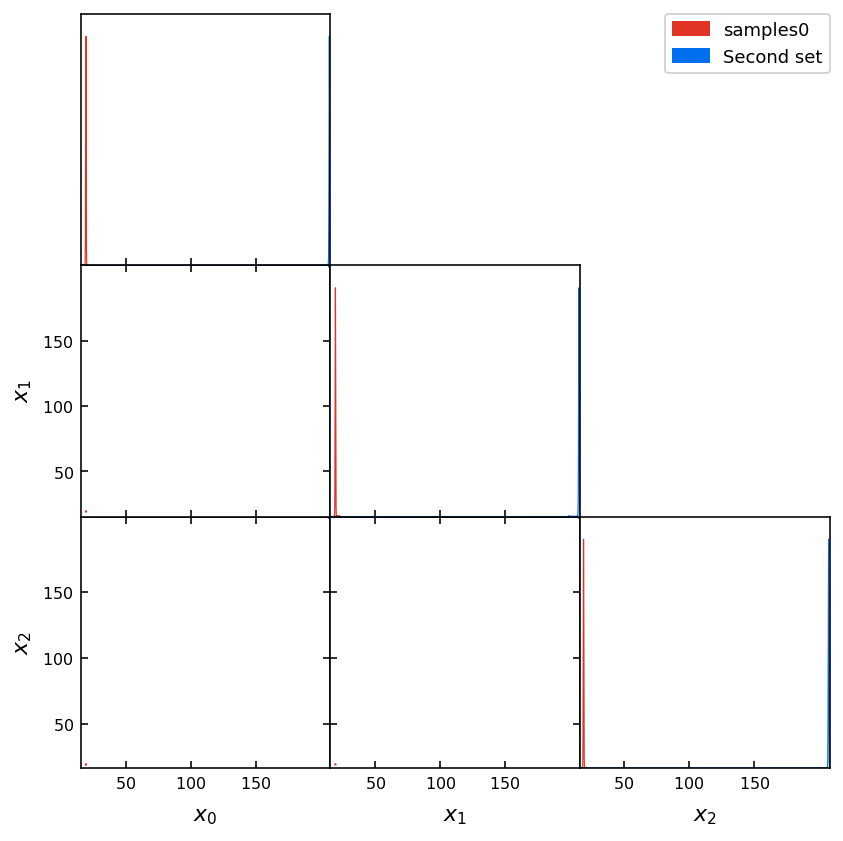

In [136]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples1, samples2], filled=True);

# Emcee para cadenas de MCMC

In [ ]:
import emcee

We’re going to demonstrate how you might draw samples from the multivariate Gaussian density given by:

p(x⃗ )∝exp[−12(x⃗ −μ⃗ )TΣ−1(x⃗ −μ⃗ )]
where μ⃗  is an N-dimensional vector position of the mean of the density and Σ is the square N-by-N covariance matrix.
Then, we’ll code up a Python function that returns the density p(x⃗ ) for specific values of x⃗ , μ⃗  and Σ−1. In fact, emcee actually requires the logarithm of p. We’ll call it log_prob:


In [ ]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

It is important that the first argument of the probability function is the position of a single “walker” (a N dimensional numpy array). The following arguments are going to be constant every time the function is called and the values come from the args parameter of our EnsembleSampler that we’ll see soon.

Now, we’ll set up the specific values of those “hyperparameters” in 5 dimensions:

In [ ]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

How about we use 32 walkers? Before we go on, we need to guess a starting point for each of the 32 walkers. This position will be a 5-dimensional vector so the initial guess should be a 32-by-5 array. It’s not a very good guess but we’ll just guess a random number between 0 and 1 for each component:

In [ ]:
nwalkers = 32

p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

Now that we’ve gotten past all the bookkeeping stuff, we can move on to the fun stuff. The main interface provided by emcee is the EnsembleSampler object so let’s get ourselves one of those.
Remember how our function log_prob required two extra arguments when it was called? By setting up our sampler with the args argument, we’re saying that the probability function should be called as:

In [ ]:
log_prob(p0[0], means, cov)

In [ ]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

You’ll notice that I saved the final position of the walkers (after the 100 steps) to a variable called state. You can check out what will be contained in the other output variables by looking at the documentation for the EnsembleSampler.run_mcmc() function. The call to the EnsembleSampler.reset() method clears all of the important bookkeeping parameters in the sampler so that we get a fresh start. It also clears the current positions of the walkers so it’s a good thing that we saved them first.

Now, we can do our production run of 10000 steps:

In [ ]:
sampler.run_mcmc(state, 10000);

The samples can be accessed using the EnsembleSampler.get_chain() method. This will return an array with the shape (10000, 32, 5) giving the parameter values for each walker at each step in the chain. Take note of that shape and make sure that you know where each of those numbers come from. You can make histograms of these samples to get an estimate of the density that you were sampling:

In [ ]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [ ]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))